# Medium-range precipitation forecasting based on GraphCast

[![DownloadNotebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/resource/_static/logo_notebook_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.5.0/mindearth/en/medium-range/mindspore_graphcast_tp.ipynb)&emsp;[![DownloadCode](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/resource/_static/logo_download_code_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.5.0/mindearth/en/medium-range/mindspore_graphcast_tp.py)&emsp;[![View Source On Gitee](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/resource/_static/logo_source_en.svg)](https://gitee.com/mindspore/docs/blob/r2.5.0/docs/mindearth/docs/source_en/medium-range/graphcast_tp.ipynb)

## Overview

This module provides medium-range precipitation forecasting based on a pre-trained GraphCast backbone. We add a trainable graphcast module after the pre-trained backbone and fine-tune. The architecture of the model displayed in the following.  

![graphcast_tp](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/docs/mindearth/docs/source_en/medium-range/images/graphcast_tp.png)

## Technology Path

MindSpore Earth solves the problem as follows:

1. Data Construction.
2. Model Construction.
3. Loss function.
4. Model Training.
5. Model Evaluation and Visualization.



Download the training and test dataset: [dataset](https://download-mindspore.osinfra.cn/mindscience/mindearth/dataset/medium_precipitation/tiny_datasets/)

In [36]:
import random
import numpy as np
import matplotlib.pyplot as plt

from mindspore import set_seed
from mindspore import context, ops


The following `src` can be downloaded in [graphcast/src](https://gitee.com/mindspore/mindscience/tree/r0.7/MindEarth/applications/medium-range/graphcast/src).

In [8]:
from mindearth.utils import load_yaml_config
from mindearth.data import Dataset

from src import get_coe, get_logger, init_tp_model
from src import LossNet, GraphCastTrainerTp, CustomWithLossCell, InferenceModuleTp
from src import Era5DataTp

In [9]:
set_seed(0)
np.random.seed(0)
random.seed(0)

You can get parameters of model, data and optimizer from [config](https://gitee.com/mindspore/mindscience/blob/r0.7/MindEarth/applications/medium-range/graphcast/configs/GraphCastTp.yaml). Set `tp: True` in `GraphCastTp.yaml`.

In [16]:
config = load_yaml_config("./GraphCastTp.yaml")
context.set_context(mode=context.GRAPH_MODE, device_target="Ascend", device_id=5)

## Data Construction

Download the statistic, training and validation dataset from  [dataset](https://download-mindspore.osinfra.cn/mindscience/mindearth/dataset/medium_precipitation/tiny_datasets/) to `./dataset`.

Modify the parameter of `root_dir` and `tp_dir` in the `./GraphCastTp.yaml`, which set the directory for dataset.

The `./dataset` is hosted with the following directory structure:

```text

├── statistic
│   ├── mean.npy
│   ├── mean_s.npy
│   ├── std.npy
│   └── std_s.npy
│   └── climate_0.5_tp.npy
├── train
│   └── 2018
├── train_static
│   └── 2018
├── train_surface
│   └── 2018
├── train_surface_static
│   └── 2018
├── valid
│   └── 2021
├── valid_static
│   └── 2021
├── valid_surface
│   └── 2021
├── valid_surface_static
│   └── 2021
```


## Model Construction

You need a pre-trained ckpt of GraphCast. You could download [ckpt](https://download-mindspore.osinfra.cn/mindscience/mindearth/dataset/medium_precipitation/tiny_datasets/ckpt/). Modify the parameter of `backbone_ckpt_path` in the `./GraphCastTp.yaml`.

In [17]:
model = init_tp_model(config, run_mode='train')
logger = get_logger(config)

2023-12-05 06:21:28,126 - utils.py[line:165] - INFO: {'name': 'GraphCastTp', 'latent_dims': 512, 'processing_steps': 10, 'recompute': True, 'vm_in_channels': 3, 'em_in_channels': 4, 'eg2m_in_channels': 4, 'em2g_in_channels': 4}
2023-12-05 06:21:28,126 - utils.py[line:165] - INFO: {'name': 'GraphCastTp', 'latent_dims': 512, 'processing_steps': 10, 'recompute': True, 'vm_in_channels': 3, 'em_in_channels': 4, 'eg2m_in_channels': 4, 'em2g_in_channels': 4}
2023-12-05 06:21:28,127 - utils.py[line:165] - INFO: {'name': 'era5', 'root_dir': './dataset_tp', 'feature_dims': 69, 'pressure_level_num': 13, 'data_sink': False, 'batch_size': 1, 't_in': 1, 't_out_train': 1, 't_out_valid': 20, 't_out_test': 20, 'train_interval': 1, 'valid_interval': 1, 'test_interval': 1, 'pred_lead_time': 6, 'data_frequency': 6, 'train_period': [2018, 2018], 'valid_period': [2021, 2021], 'test_period': [2022, 2022], 'patch': False, 'rollout_steps': 1, 'num_workers': 1, 'mesh_level': 5, 'grid_resolution': 0.5, 'tp': Tru

## Loss Function

LP Loss, relative error.

In [18]:
sj_std, wj, ai = get_coe(config)
data_params = config.get('data')
loss_fn = LossNet(ai, wj, sj_std, data_params.get('feature_dims'), data_params['tp'])
loss_cell = CustomWithLossCell(backbone=model, loss_fn=loss_fn, data_params=data_params)

In [19]:
trainer = GraphCastTrainerTp(config, model, loss_cell, logger)
trainer.train()

## Model Evaluation and Visualization

After training, we use the 20th checkpoint for inference. The visualization of predictions and ground truth is shown below.

In [33]:
inference_module = InferenceModuleTp(model, config, logger)
test_dataset_generator = Era5DataTp(data_params=data_params, run_mode='test')
test_dataset = Dataset(test_dataset_generator, distribute=False,
                       num_workers=data_params.get('num_workers'), shuffle=False)
test_dataset = test_dataset.create_dataset(data_params.get('batch_size'))
data = next(test_dataset.create_dict_iterator())
inputs = data['inputs']
labels = data['labels']
print(inputs.shape)

(1, 259200, 69)


In [34]:
def unlog_trans(x, eps=1e-5):
    """Inverse transformation of log(TP / epsilon + 1)"""
    return eps * (ops.exp(x) - 1)

pred = inference_module.forecast(inputs)
labels = unlog_trans(labels).asnumpy()
pred = unlog_trans(pred).asnumpy()
print(labels.shape, pred.shape)

(1, 20, 360, 720) (1, 20, 360, 720)


In [43]:
def plt_comparison(pred, label, root_dir='./images'):
    plt.subplot(1, 2, 1)
    plt.imshow(label, cmap='jet')
    plt.title('Truth')
    plt.xticks(np.arange(0, 721, 180), np.arange(-180, 181, 90))
    plt.xlabel('longitude')
    plt.yticks(np.arange(0, 361, 180), np.arange(-90, 91, 90))
    plt.ylabel('latitude')
    plt.subplot(1, 2, 2)
    plt.imshow(pred, cmap='jet')
    plt.title('pred')
    plt.xticks(np.arange(0, 721, 180), np.arange(-180, 181, 90))
    plt.xlabel('longitude')
    plt.yticks(np.arange(0, 361, 180), np.arange(-90, 91, 90))
    plt.savefig(f"{root_dir}/tp_comparison.png", dpi=150)
    plt.show()

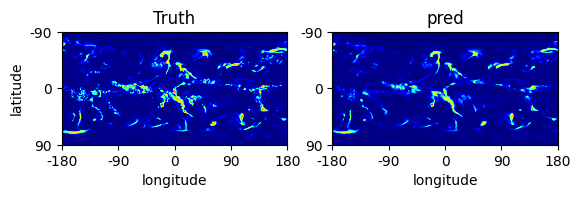

In [44]:
def trans_colorbar(data):
    ori = [0., 1., 10., 100]
    new_v = [0., 50., 75, 100.]
    trans = []
    for i in range(1, len(ori)):
        x = np.where((data > ori[i-1]) & (data <= ori[i]), (data - ori[i-1]) * (new_v[i] - new_v[i-1]) / (ori[i] - ori[i-1]) + new_v[i-1], 1.)
        trans.append(x)
    res = 1.
    for x in trans:
        res *= x
    return res

plot_pred = trans_colorbar(pred[0, 1] * 1000)
plot_labels = trans_colorbar(labels[0, 1] * 1000)
plt_comparison(plot_pred, plot_labels)